In [59]:
# imports
import os
os.sys.path.append(os.path.abspath("../.."))

import tensorflow as tf

import pandas as pd
import numpy as np
import h5py

from matplotlib import pyplot as plt

from project.notebooks_utils import visuals

from IPython.display import display

import project.download_content as content

from project.utils import data
from project.model.loss import BBOX_REF

from keras.preprocessing import image

from project.model.ssd_model_300_full import ssd_model_300
from project.model.loss import SSDloss

from project.utils.train_test.data_bbox_match_hdf5 import load_model
from project.utils.category_encoder import CategoryEncoder

from project.utils import data_augmentation as da

# one hot encoding
ohc = load_model()

modelpath = os.path.join(os.path.abspath(content.DATAPATH), 'MODEL') 

val_files = [os.path.join(modelpath, f'39_classes_300x300_cross_val_{i}.h5')
             for i in range(8)]

test_files = [os.path.join(modelpath, f'39_classes_300x300_test_{i}.h5')
              for i in range(8)]

### Loading one image

In [2]:
# loading a random file of validation dataset
with h5py.File(val_files[3], 'r') as f:
    # selecting a random batch and getting their references
    x_ref, y_ref, info, bboxes_ref = f['batches'][3]
    
    # getting Images and Targets from the batch chosen
    X = f[x_ref][:]
    y = f[y_ref][:]
    info = f[info][:]
    
display(X.shape)
display(y.shape)
display(info.shape)

bboxes_ref

(300, 300, 300, 3)

(300, 8732, 44)

(300, 2)

'f0bd2837-8b79-4de2-a986-ec0a4bf9708d-bboxes'

In [51]:
sample = 53

# getting a specific image from the batch
img = X[sample]

# getting it target
target = y[sample]

# metadata about the image
id, raw_path = info[sample]

with h5py.File(val_files[3], 'r') as f:
    bboxes = f[bboxes_ref][id][:]

# validate that target has at least one bboxes matched
# (containing 1 and 0 in the first columns (no-class))
display(set(target[:, 0]))

bboxes

{0.0, 1.0}

array([[0.    , 0.    , 0.    , ..., 0.4502, 0.8613, 0.9004],
       [0.    , 0.    , 0.    , ..., 0.2456, 0.5767, 0.4912],
       [0.    , 0.    , 0.    , ..., 0.447 , 0.8584, 0.894 ],
       [0.    , 0.    , 0.    , ..., 0.5996, 0.674 , 0.6196]],
      dtype=float16)

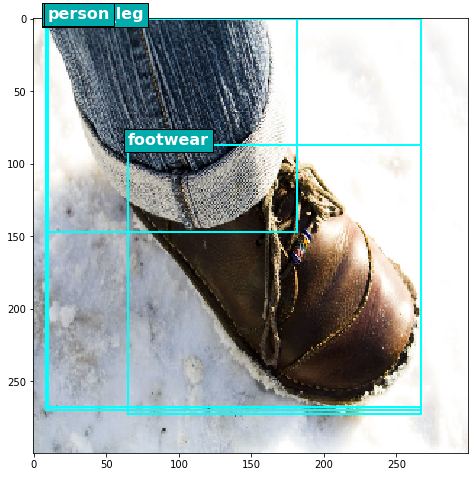

In [56]:
img_jpg = image.load_img('../' + raw_path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img_jpg)

visuals.draw_many_bboxes(img_jpg, bboxes[:, -4:],
                         label=ohc.inverse_transform(bboxes[:, :-4]));

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [16]:
model = ssd_model_300()

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Training

In [17]:
model.load_weights(content.DATAPATH + '/full-weights300vgg16.h5')

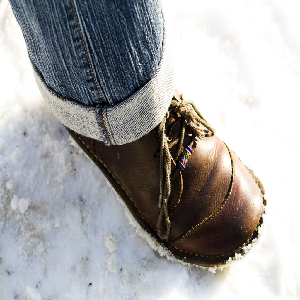

In [8]:
image.array_to_img(img)

In [102]:
norm_img = da.normalize(img)
norm_img

array([[[0.1059 , 0.0941 , 0.06665],
        [0.251  , 0.2157 , 0.1804 ],
        [0.3254 , 0.306  , 0.2825 ],
        ...,
        [0.349  , 0.349  , 0.349  ],
        [0.349  , 0.349  , 0.349  ],
        [0.349  , 0.349  , 0.349  ]],

       [[0.1726 , 0.1569 , 0.1137 ],
        [0.2783 , 0.255  , 0.2079 ],
        [0.3333 , 0.3215 , 0.2864 ],
        ...,
        [0.349  , 0.349  , 0.349  ],
        [0.349  , 0.349  , 0.349  ],
        [0.349  , 0.349  , 0.349  ]],

       [[0.2354 , 0.2079 , 0.1686 ],
        [0.2864 , 0.2627 , 0.2157 ],
        [0.3372 , 0.3254 , 0.298  ],
        ...,
        [0.349  , 0.349  , 0.349  ],
        [0.349  , 0.349  , 0.349  ],
        [0.349  , 0.349  , 0.349  ]],

       ...,

       [[0.051  , 0.0784 , 0.1177 ],
        [0.06665, 0.102  , 0.1372 ],
        [0.04706, 0.08234, 0.1098 ],
        ...,
        [0.3137 , 0.3176 , 0.298  ],
        [0.306  , 0.306  , 0.306  ],
        [0.2864 , 0.2864 , 0.2864 ]],

       [[0.051  , 0.0784 , 0.1177 ],
  

In [95]:
pred = model.predict(np.expand_dims(norm_img, axis=0))[0]

for i, r in enumerate(pred):
    if r[0] < 0.5:
        print(i)

8728
8731


In [98]:
np.argmax(pred[8728, :-4])

0

In [99]:
pred[8728]

array([ 4.7275990e-01,  3.5963324e-03,  8.2915900e-03,  8.9790104e-03,
        6.4099468e-02,  2.9467279e-02,  2.1823668e-03,  2.5618846e-02,
        1.8118961e-03,  2.0349279e-02,  1.2362709e-02,  1.1526644e-03,
        1.3158696e-02,  2.4118317e-02,  1.7711815e-03,  6.3385973e-03,
        3.3800624e-04,  1.3662954e-02,  2.0901638e-03,  6.4256624e-04,
        2.3866412e-03,  8.9366717e-04,  2.6210290e-04,  3.1315655e-04,
        1.0069266e-02,  5.0278637e-03,  4.8250541e-02,  5.8163382e-02,
        2.8812533e-02,  6.4936732e-03,  4.0130015e-03,  3.4669798e-04,
        3.7833289e-03,  7.6964102e-03,  1.3202534e-03,  6.2137410e-02,
        4.1008936e-03,  2.7866273e-03,  6.8336437e-03,  3.3517115e-02,
        5.9926502e-02,  1.7114118e-01, -8.3693379e-01, -7.2441286e-01],
      dtype=float32)

In [41]:
target = CategoryEncoder.transform(bboxes)
np.argmax(target[:, :-4], axis=1)

array([20,  0, 26, 10])

In [55]:
for i, r in enumerate(target[:, 0]):
    if r == 0:
        print(i)

8728
8729
8730
8731


1

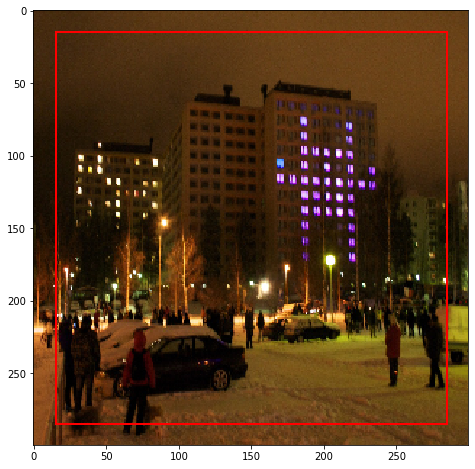

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        [cx, cy, w, h]
        
        visuals.draw_bbox(img, ref, color="#ff0000")
tt

1

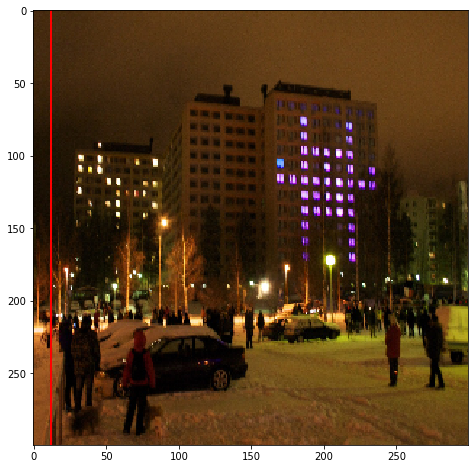

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        
        
        visuals.draw_bbox(img, [cx, cy, w, h], color="#ff0000")
tt

In [17]:
h

2.243039